### Author = 'Timothy McDonough'
### Email = 'timothylmcdonough@gmail.com'

In [1]:
### 4b. Modeling and Analysis

Importing libraries to perform model analysis:

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Lets define "FeatureGenerator" and "ModelContainer" classes to create functions needed to perform the model analysis:

In [47]:
class FeatureGenerator:
    def __init__(self, data):
        '''initializes class and creates groupby object for data'''
        self.data = data
        #able to generate features for new companies, but less accurate
        #self.cat_cols = ['jobType', 'degree', 'major', 'industry']
        self.cat_cols = data.cat_cols
        self.groups = data.train_df.groupby(self.cat_cols)
        
    def add_group_stats(self):
        '''adds group statistics to data stored in data object'''
        #get group stats
        group_stats_df = self._get_group_stats()
        group_stats_df.reset_index(inplace=True)
  
        #merge derived columns to original df
        self.data.train_df = self._merge_new_cols(self.data.train_df, group_stats_df, self.cat_cols, fillna=True)
        self.data.test_df = self._merge_new_cols(self.data.test_df, group_stats_df, self.cat_cols, fillna=True)      
        
        #update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(self.data, cat_cols=group_stats_cols)  
        
    def _get_group_stats(self):
        '''calculates group statistics'''
        target_col = self.data.target_col
        group_stats_df = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        group_stats_df['group_max'] = self.groups[target_col].max()
        group_stats_df['group_min'] = self.groups[target_col].min()
        group_stats_df['group_std'] = self.groups[target_col].std()
        group_stats_df['group_median'] = self.groups[target_col].median()
        return group_stats_df
        
    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        '''merges engineered features with original df'''
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def _extend_col_lists(self, data, cat_cols=[], num_cols=[]):
        '''addes engineered feature cols to data col lists'''
        data.num_cols.extend(num_cols)
        data.cat_cols.extend(cat_cols)
        data.feature_cols.extend(num_cols + cat_cols)


class ModelContainer:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        #self.default_num_iters = default_num_iters
        #self.verbose_lvl = verbose_lvl
        
    def add_model(self, model):
        self.models.append(model)

    def cross_validate(self, data, k=3, num_procs=1):
        '''cross validate models using given data'''
        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
    
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        pass
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))

        feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
        feature_importances.plot.bar()
        plt.show()


Model Summaries:


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) - MSE: 5168.409186943802

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=80,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False) - MSE: 5248.7010193285605

 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight

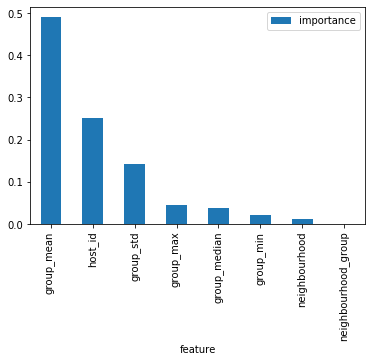

In [58]:
#model analysis and selection
if __name__ == '__main__':
    
    #move working directory to correct location
    os.chdir('/Users/timothylmcdonough/DSDJ/NYC_AirBnB')
    
    #define number of processors to use for parallel runs
    num_procs = 4

    #set verbose level for models
    verbose_lvl = 0

    #define input files
    train_feature_file = 'Data/train_features.csv'
    train_target_file = 'Data/train_prices.csv'
    test_file = 'Data/test_features.csv'

    #define variables
    #cat_cols = ['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']
    cat_cols = ['neighbourhood_group', 'neighbourhood']

    #num_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
    num_cols = ['host_id']
    target_col = 'price'
    id_col = 'name'

    #turn feature engineering on
    engineer_features = True
    
    #Create Data object
    data = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)
    
    #Engineer features
    if engineer_features:
        feature_generator = FeatureGenerator(data)
        feature_generator.add_group_stats()

    #Create model container and add models to it
    models = ModelContainer()

    #create models -- hyperparameter tuning already done by hand for each model
    models.add_model(LinearRegression())
    models.add_model(RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80,                                        max_features=8, verbose=verbose_lvl))
    models.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))

    #Cross validate models, then select, fit, and score test data with best model
    models.cross_validate(data, k=2, num_procs=num_procs)
    models.select_best_model()
    models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
    models.best_model_predict(data.test_df[data.feature_cols])

    #Summarize results
    models.print_summary()